# Dark Matter Analysis of the Draco dSph Galaxy

This tutorial demonstrates how to perform an analysis of the Draco dSph galaxy.  This tutorial assumes that you have first gone through the [PG 1553](PG 1553+113.ipynb) analysis tutorial.  In this example we will use the following data selection which is chosen to match the selection used in the [6-year LAT Dwarf Analysis](http://arxiv.org/abs/1503.02641).

* 10x10 degree ROI
* Start Time (MET) = 239557417 seconds
* Stop Time (MET) = 428903014 seconds
* Minimum Energy = 500 MeV
* Maximum Energy = 500000 MeV
* P8R2_SOURCE_V6 (evclass=128)


## Get the Data and Setup the Analysis

For this thread we will use a pregenerated data set which is contained in the following tar archive.

In [51]:
!wget -nc http://www.slac.stanford.edu/~mdwood/fermipy/draco.tar.gz
!tar xzf draco.tar.gz

File ‘draco.tar.gz’ already there; not retrieving.



To get started we will first instantiate a GTAnalysis instance using the config file in the draco directory and the run the setup() method.  This will prepare all the ancillary files and create the pylikelihood instance for binned analysis.  Note that in this example these files have already been generated so the routines that would normally be executed to create these files will be skipped.

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from fermipy.gtanalysis import GTAnalysis
gta = GTAnalysis('draco/config.yaml')
gta.setup()
gta.write_roi('fit0')

2015-11-17 15:21:01 - GTAnalysis - INFO - 
--------------------------------------------------------------------------------
This is fermipy version 0.5.0-31-g0b44-dirty.
2015-11-17 15:21:01 - GTAnalysis - INFO - Configuration:
binning:
  binsperdec: 8
  binsz: 0.1
  coordsys: GAL
  enumbins: null
  npix: null
  proj: AIT
  roiwidth: 10.0
components: null
data:
  evfile: draco_ft1.fits
  ltcube: ltcube_239557414_428903014_z100_r180_gti.fits
  scfile: null
extension:
  fix_background: false
  save_model_map: false
  save_templates: false
  spatial_model: GaussianSource
  width: null
  width_max: 1.0
  width_min: 0.00316
  width_nstep: 26
fileio:
  logfile: /Users/mdwood/fermi/fermipy/notebooks/draco/fermipy
  outdir: /Users/mdwood/fermi/fermipy/notebooks/draco
  savefits: true
  scratchdir: /scratch
  usescratch: false
  workdir: null
gtlike:
  bexpmap: null
  convolve: true
  edisp: true
  edisp_disable:
  - isodiff
  - galdiff
  irfs: P8R2_SOURCE_V6
  likelihood: binned
  minbinsz: 0.0

## Print the ROI model

We can print the ROI object to see a list of sources in the model along with their distance from the ROI center (offset), TS, and number of predicted counts (Npred).  Since we haven't yet fit any sources, the ts of all sources will initially be assigned as nan.

In [53]:
gta.print_roi()

name                SpatialModel   SpectrumType     offset        ts       Npred
--------------------------------------------------------------------------------
3FGL J1658.3+6149   PointSource    PowerLaw          0.000       nan       141.3
3FGL J1647.4+4950   PointSource    PowerLaw          0.000       nan         5.9
3FGL J1732.7+5914   PointSource    PowerLaw          0.000       nan       123.0
3FGL J1807.8+6427   PointSource    PowerLaw          0.000       nan         1.6
3FGL J1722.7+6104   PointSource    PowerLaw          0.000       nan       203.8
draco               PointSource    PowerLaw          0.000       nan         0.0
3FGL J1731.9+5428   PointSource    PowerLaw          0.000       nan       206.3
3FGL J1625.0+5651   PointSource    PowerLaw          0.000       nan         2.2
3FGL J1740.4+5347   PointSource    PowerLaw          0.000       nan       152.3
3FGL J1637.9+5719   PointSource    PowerLaw          0.000       nan        33.9
3FGL J1645.9+6336   PointSou

We can assess the quality of our pre-fit model by running the residmap method.  This will generate four maps

2015-11-17 15:21:36 - GTBinnedAnalysis - INFO - Loading /Users/mdwood/fermi/fermipy/notebooks/draco/fit0_00.xml
2015-11-17 15:21:36 - GTAnalysis - INFO - Generating residual maps
2015-11-17 15:21:36 - ResidMapGenerator - INFO - Generating Residual map
2015-11-17 15:21:36 - ResidMapGenerator - INFO - {'Index': 2.0, 'SpatialModel': 'PointSource'}
2015-11-17 15:21:37 - GTAnalysis - INFO - Adding source testsource
2015-11-17 15:21:40 - GTAnalysis - INFO - Deleting source testsource


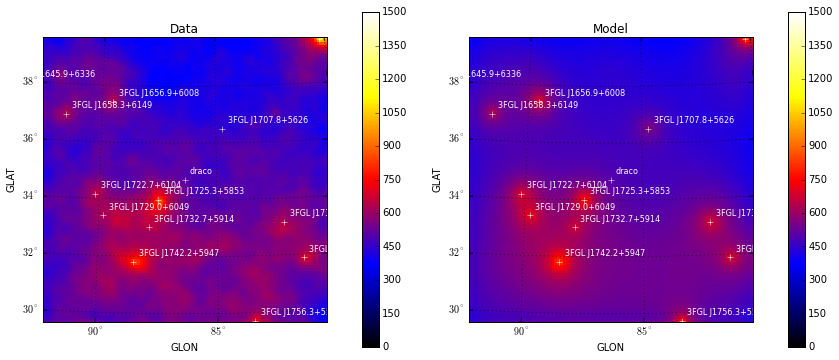

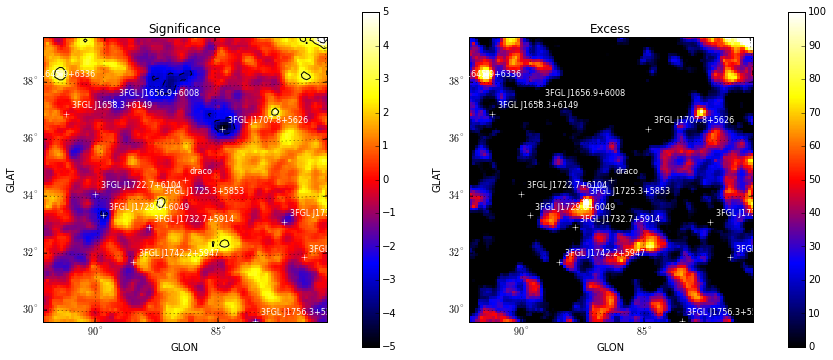

In [54]:
gta.load_roi('fit0')
resid = gta.residmap('draco_prefit',
                models=[{'SpatialModel' : 'PointSource', 'Index' : 2.0}])
from fermipy.plotting import ROIPlotter
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid[0]['data'],gta.roi).plot(vmin=0,vmax=1500,subplot=121)
plt.gca().set_title('Data')
ROIPlotter(resid[0]['model'],gta.roi).plot(vmin=0,vmax=1500,subplot=122)
plt.gca().set_title('Model')

fig = plt.figure(figsize=(14,6))
ROIPlotter(resid[0]['sigma'],gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5],subplot=121)
plt.gca().set_title('Significance')
ROIPlotter(resid[0]['excess'],gta.roi).plot(vmin=0,vmax=100,subplot=122)
plt.gca().set_title('Excess')


Now we will run the *optimize* method.  This method will iteratively optimize the parameters of all components in the ROI in several stages:
* Simultaneously fitting the normalization of the brightest model components containing at least some fraction of the total model counts (default 95%).
* Individually fitting the normalization of all remaining sources if they have Npred above some threshold (default 1).
* Individually fitting the normalization and shape of any component with TS larger than some threshold (default 100).

Running *optimize* gives us a baseline model that we can use as a starting point for subsequent stages of the analysis.  We will also save the results of the analysis with write_roi.  By saving the analysis state we can restore the analysis to this point at any time with the *load_roi* method.

In [55]:
gta.optimize()
gta.write_roi('fit1')

2015-11-17 15:21:52 - GTAnalysis - INFO - Running ROI Optimization
2015-11-17 15:25:24 - GTAnalysis - INFO - Finished ROI Optimization
2015-11-17 15:25:24 - GTAnalysis - INFO - LogLike: -60833.645399 Delta-LogLike: 58.211925
2015-11-17 15:25:24 - GTBinnedAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/draco/fit1_00.xml...
2015-11-17 15:25:24 - GTBinnedAnalysis - INFO - Generating model map for component 00.
2015-11-17 15:25:34 - GTAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/draco/fit1.yaml...
2015-11-17 15:25:37 - GTAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/draco/fit1.npy...


After running *optimize* we can rerun *print_roi* to see a summary of the updated model.  All sources that were fit in this step now have ts values and an Npred value the reflects the optimized normalization of that source.  Note that model components that were not fit during the optimize step still have ts=nan.

In [56]:
gta.print_roi()

name                SpatialModel   SpectrumType     offset        ts       Npred
--------------------------------------------------------------------------------
3FGL J1658.3+6149   PointSource    PowerLaw          0.000     49.01       112.5
3FGL J1647.4+4950   PointSource    PowerLaw          0.000      0.09        14.0
3FGL J1732.7+5914   PointSource    PowerLaw          0.000      7.65        47.7
3FGL J1807.8+6427   PointSource    PowerLaw          0.000      0.00         1.1
3FGL J1722.7+6104   PointSource    PowerLaw          0.000     25.70       138.3
draco               PointSource    PowerLaw          0.000       nan         0.0
3FGL J1731.9+5428   PointSource    PowerLaw          0.000     25.11       146.0
3FGL J1625.0+5651   PointSource    PowerLaw          0.000     -0.00         0.0
3FGL J1740.4+5347   PointSource    PowerLaw          0.000     75.64       134.7
3FGL J1637.9+5719   PointSource    PowerLaw          0.000     -0.01         0.5
3FGL J1645.9+6336   PointSou

To inspect the quality of the optimized model we can rerun the residmap method.  In the updated residual map that we see that there is no longer a negative residual in the vicinity of J1707.

2015-11-17 15:25:45 - GTBinnedAnalysis - INFO - Loading /Users/mdwood/fermi/fermipy/notebooks/draco/fit1_00.xml
2015-11-17 15:25:45 - GTAnalysis - INFO - Generating residual maps
2015-11-17 15:25:45 - ResidMapGenerator - INFO - Generating Residual map
2015-11-17 15:25:45 - ResidMapGenerator - INFO - {'Index': 2.0, 'SpatialModel': 'PointSource'}
2015-11-17 15:25:45 - GTAnalysis - INFO - Adding source testsource
2015-11-17 15:25:48 - GTAnalysis - INFO - Deleting source testsource


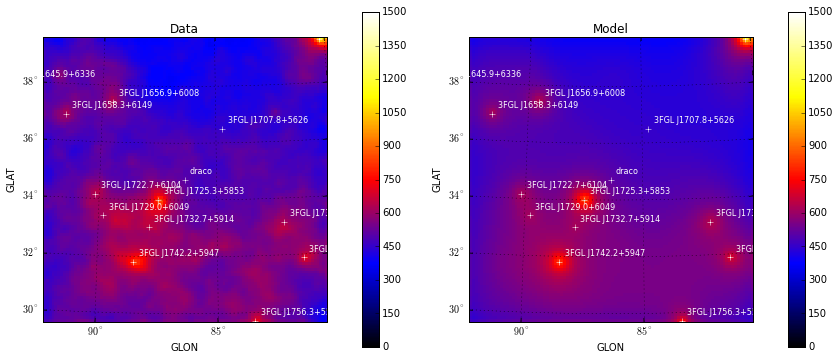

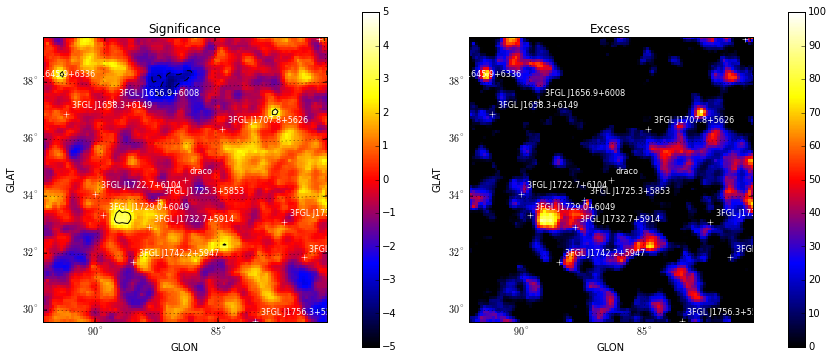

In [57]:
gta.load_roi('fit1')
resid = gta.residmap('draco_postfit',
                models=[{'SpatialModel' : 'PointSource', 'Index' : 2.0}])
from fermipy.plotting import ROIPlotter
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid[0]['data'],gta.roi).plot(vmin=0,vmax=1500,subplot=121)
plt.gca().set_title('Data')
ROIPlotter(resid[0]['model'],gta.roi).plot(vmin=0,vmax=1500,subplot=122)
plt.gca().set_title('Model')

fig = plt.figure(figsize=(14,6))
ROIPlotter(resid[0]['sigma'],gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5],subplot=121)
plt.gca().set_title('Significance')
ROIPlotter(resid[0]['excess'],gta.roi).plot(vmin=0,vmax=100,subplot=122)
plt.gca().set_title('Excess')

## Spectral Analysis

After optimizing the ROI model we are ready to perform our analysis of the source of interest (draco).  We will begin by freeing draco along with all other point sources within 3 deg of the ROI center and refitting their normalizations.

In [58]:
gta.free_sources(distance=3.0,pars='norm')
gta.free_sources(distance=3.0,pars='shape',min_ts=100.)
gta.fit()

3

After running the fit completes we can execute the spectral analysis of draco with the sed method.  For comparison we will also perform the spectral analysis of a nearby source (3FGL J1725.3+5853).

In [59]:
sed_draco = gta.sed('draco')
sed_j1725 = gta.sed('3FGL J1725.3+5853')
gta.write_roi('fit_sed')

2015-11-17 15:27:13 - GTAnalysis - INFO - Computing SED for draco
2015-11-17 15:29:17 - GTAnalysis - INFO - Computing SED for 3FGL J1725.3+5853
2015-11-17 15:31:24 - GTBinnedAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/draco/fit_sed_00.xml...
2015-11-17 15:31:24 - GTBinnedAnalysis - INFO - Generating model map for component 00.
2015-11-17 15:31:33 - GTAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/draco/fit_sed.yaml...
2015-11-17 15:31:38 - GTAnalysis - INFO - Writing /Users/mdwood/fermi/fermipy/notebooks/draco/fit_sed.npy...


We can now inspect the fit results by looking at the elements of the output dictionary.  By default the sed method will perform a likelihood scan in each energy bin which is saved in the *lnlprofile* element.  In the following example we plot the likelihood profile in the first energy bin and overplot the flux upper limit in that bin (vertical black line).  fermiPy uses the delta-log-likelihood method to evaluate ULs and we can see that the 95% CL flux upper limit intersects with the point at which the log-likelihood has decreased by 2.71/2 from its maximum value (horizontal red line).

[  5.67391933e-07   7.34002329e-08   3.63210381e-07   1.68984697e-07
   2.75734756e-07   7.23628211e-08   9.19712616e-08   1.53018541e-07
   1.13123081e-07   1.44912322e-07   1.65460228e-07   5.50572657e-07
   2.78073000e-07   4.44186932e-07   5.05651043e-07   1.01321992e-06
   8.22583093e-07   1.10001439e-06   1.47326446e-06   1.97477638e-06
   2.64120211e-06   3.55002736e-06   4.74874323e-06   6.52638092e-06]


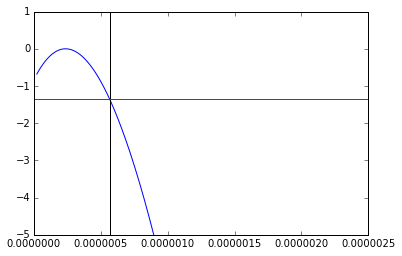

In [60]:
# E^2 x Differential flux ULs in each bin in units of MeV cm^{-2} s^{-1}
print sed_draco['e2dfde_ul95']

lnlprof = sed_draco['lnlprofile']

plt.figure()
plt.plot(lnlprof[0]['dfde']*10**(2*sed_draco['ecenter'][0]),
        lnlprof[0]['dlogLike'])
plt.gca().set_ylim(-5,1)
plt.gca().axvline(sed_draco['e2dfde_ul95'][0],color='k')
plt.gca().axhline(-2.71/2.,color='r')

We can also visualize the results of the scan with the SEDPlotter class.  This class accepts a source object as its argument and creates a visualization of the SED as a sequence of points with errors.  Setting showlnl=True overplots the likelihood function in each bin as a color gradient (the so-called castro plot).

(1e-08, 1e-05)

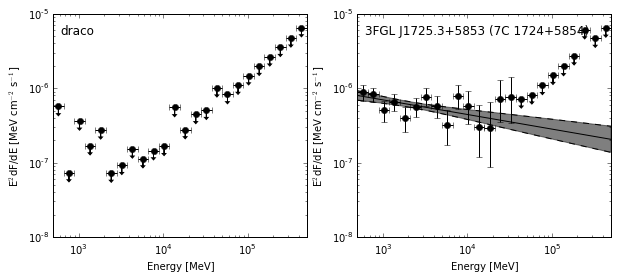

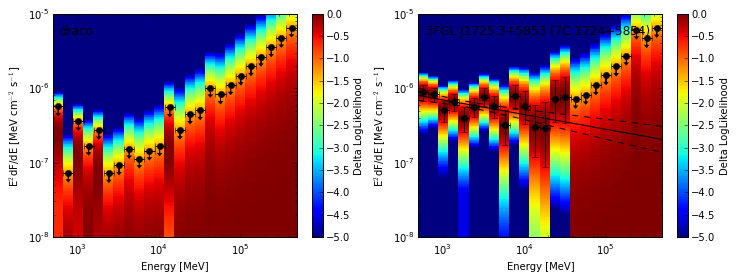

In [61]:
from fermipy.plotting import SEDPlotter

fig = plt.figure(figsize=(10,4))

fig.add_subplot(121)
SEDPlotter(gta.roi['draco']).plot()
plt.gca().set_ylim(1E-8,1E-5)

fig.add_subplot(122)
SEDPlotter(gta.roi['3FGL J1725.3+5853']).plot()
plt.gca().set_ylim(1E-8,1E-5)

fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
SEDPlotter(gta.roi['draco']).plot(showlnl=True)
plt.gca().set_ylim(1E-8,1E-5)

fig.add_subplot(122)
SEDPlotter(gta.roi['3FGL J1725.3+5853']).plot(showlnl=True)
plt.gca().set_ylim(1E-8,1E-5)


# Setting DM Upper Limits

Now that we have run a spectral analysis we can use the bin-by-bin likelihoods to gamma-ray flux from DM annihilations in Draco.  In the following sample code we demonstrate how to calculate the UL on the DM cross section for a given DM spectral model.  

Sigma-V Upper Limit:  3.60371605227e-26


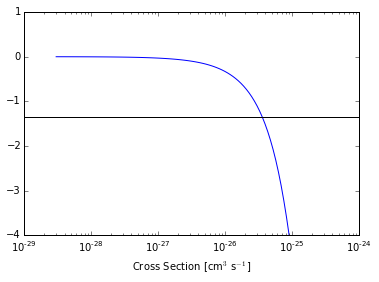

In [66]:
import pyLikelihood
import os

# Load the sed data structure
data = np.load('draco/fit_sed.npy').flat[0]
data = data['sources']['draco']['sed']

# Instantiate a DM Fit Function for a DM particle spectrum given the following parameters
# Mass = 100 GeV
# Cross-Section: 3 x 10^{-26} cm^{3} s^{-1}
# J-Factor: 10^19 GeV^2 cm^{-5}
# Channel: b-bbar
dmf = pyLikelihood.DMFitFunction()
dmf.readFunction(os.path.expandvars('draco/gammamc_dif.dat'))
dmf.setParam('norm',1E19)
dmf.setParam('sigmav',3E-26)
dmf.setParam('mass',100.0)
dmf.setParam('bratio',1.0)
dmf.setParam('channel0',4)

def integrate_eflux(fn,ebins,nstep=10):
    """Compute energy flux within a sequence of energy bins."""
    
    loge = np.linspace(ebins[0],ebins[-1],100)
    dfde = [fn(pyLikelihood.dArg(10**x)) for x in loge]        
    dfde = np.array(dfde)
    x = ebins
    dx = (x[1:] - x[:-1])

    yedge = x[1:,np.newaxis] + np.linspace(0,1,nstep)[np.newaxis,:]*dx[:,np.newaxis] 
    dy = 10**yedge[:,1:]-10**yedge[:,:-1]
    y = 0.5*(yedge[:,1:]+yedge[:,:-1])
    eflux = np.interp(np.ravel(y),loge,dfde)
    eflux = np.sum(eflux.reshape(y.shape)*10**y*dy,axis=1)

    return eflux

class SEDLike(object):

    def __init__(self,sed):
        self._sed = sed

    def __call__(self,eflux):
        lnl = np.zeros(eflux.shape)
        for i, ecenter in enumerate(self._sed['ecenter']):
            v = np.interp(eflux[i],
                          self._sed['lnlprofile'][i]['eflux'],
                          self._sed['lnlprofile'][i]['dlogLike'])
            lnl[i] += v
        return np.sum(lnl,axis=0)

ebins = np.array(list(data['emin']) + list([data['emax'][-1]]))
eflux = integrate_eflux(dmf,ebins)
sigmav = 3.E-26*np.logspace(-3.,1.,101)
eflux = eflux[:,np.newaxis]*np.logspace(-3,1,101)[np.newaxis,:]

slike = SEDLike(data)
lnl = slike(eflux)
lnl -= np.max(lnl)

# Plot log-likelihood profile

plt.figure()
plt.plot(sigmav,lnl)
plt.gca().set_xscale('log')
plt.gca().axhline(-2.71/2.,color='k')
plt.gca().set_ylim(-4,1)
plt.gca().set_xlabel('Cross Section [cm$^{3}$ s$^{-1}$]')

sigmav_ul = float(np.interp(2.71/2.,-lnl,sigmav))

print 'Sigma-V Upper Limit: ', sigmav_ul